<a href="https://colab.research.google.com/github/ZoraizQ/brain_mas_classifier/blob/master/brain_mas_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifier for Human Brain Mental Attention State using EEG BCI-based data

In [162]:
import os
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import AveragePooling2D
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam, RMSprop
from keras import regularizers
from keras.callbacks import ModelCheckpoint



SAMP_FREQ = 128 # SAMPLING FREQUENCY Hz (samples/second)
CLASSES = {
    0: 'focused',
    1: 'unfocused',
    2: 'drowsy'
}

ONEHOT = {
    0: np.array([1,0,0]),
    1: np.array([0,1,0]),
    2: np.array([0,0,1])
}

In [163]:
! [ ! -f '/content/eeg-data.zip' ] && gdown 'https://drive.google.com/uc?id=163LQWJzuyUy5nQlNsLWg4o-IiQJ72IbN'
! [ ! -d '/content/data' ] && unzip '/content/eeg-data.zip' -d '/content/data' 

# Data Preprocessing

In [164]:
DATA_FOLDER = '/content/data'

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.mat')))

NUM_FILES_ALL = len(filenames) # with habituation and trial experiments both
print("Total number of records: " + str(NUM_FILES_ALL))

'''
Each participant took part in 7 experiments, performing at most one experiment per day. 
The first 2 experiments were used for habituation, and the last 5 trials were used for collecting the data. 
The first 7 experiments belong to Subject 1, the next 7 experiments belong to Subject 2, and go on. 
However, Subject 5 could not complete the last experiment. 
Therefore, there are 34 records in the dataset.
'''


img_folder_path = '/'.join(filenames[0].split('/')[:-1])
filenames_trials = []  # remove records of habituation first, second of each subject's set out of 7
for i in range(3, NUM_FILES_ALL, 7):
    for j in range(i, min(i+5, NUM_FILES_ALL+1)):
        filenames_trials.append(img_folder_path+'/'+'eeg_record'+str(j)+'.mat')

print(filenames_trials)
NUM_FILES = len(filenames_trials)
print("Number of trial experiment records: " + str(NUM_FILES))

Total number of records: 34
['/content/data/EEG Data/eeg_record3.mat', '/content/data/EEG Data/eeg_record4.mat', '/content/data/EEG Data/eeg_record5.mat', '/content/data/EEG Data/eeg_record6.mat', '/content/data/EEG Data/eeg_record7.mat', '/content/data/EEG Data/eeg_record10.mat', '/content/data/EEG Data/eeg_record11.mat', '/content/data/EEG Data/eeg_record12.mat', '/content/data/EEG Data/eeg_record13.mat', '/content/data/EEG Data/eeg_record14.mat', '/content/data/EEG Data/eeg_record17.mat', '/content/data/EEG Data/eeg_record18.mat', '/content/data/EEG Data/eeg_record19.mat', '/content/data/EEG Data/eeg_record20.mat', '/content/data/EEG Data/eeg_record21.mat', '/content/data/EEG Data/eeg_record24.mat', '/content/data/EEG Data/eeg_record25.mat', '/content/data/EEG Data/eeg_record26.mat', '/content/data/EEG Data/eeg_record27.mat', '/content/data/EEG Data/eeg_record28.mat', '/content/data/EEG Data/eeg_record31.mat', '/content/data/EEG Data/eeg_record32.mat', '/content/data/EEG Data/eeg_re

data: (357224, 25)


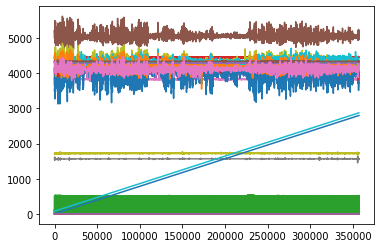


data_eeg: (357224, 14)


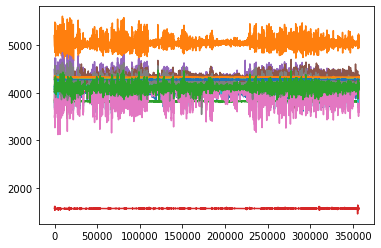


trials: (1, 2, 14, 128)

data: (380344, 25)


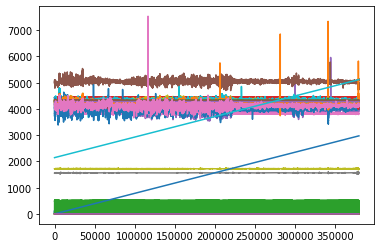


data_eeg: (380344, 14)


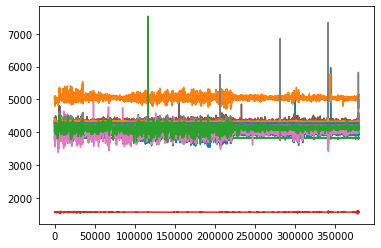


trials: (1, 2, 14, 128)

data: (351204, 25)


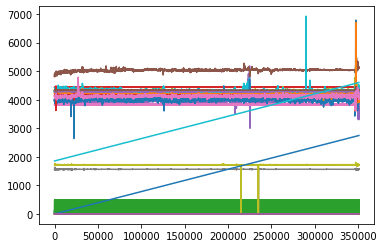


data_eeg: (351204, 14)


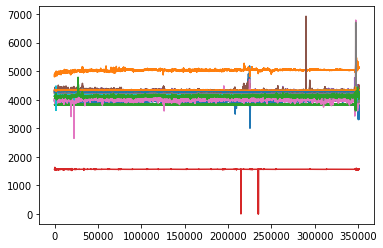


trials: (1, 2, 14, 128)

data: (288752, 25)


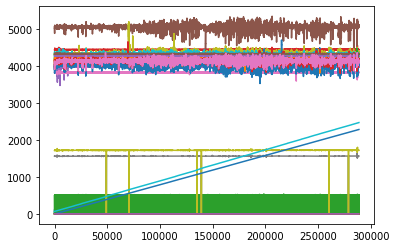


data_eeg: (288752, 14)


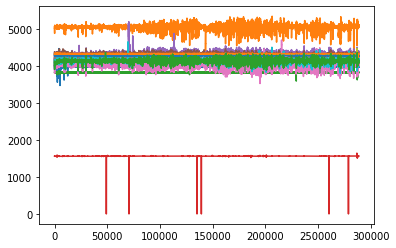


trials: (1, 2, 14, 128)

data: (398816, 25)


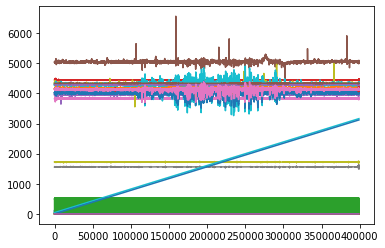


data_eeg: (398816, 14)


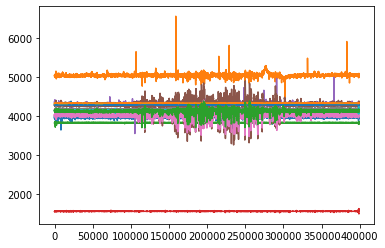


trials: (1, 3, 14, 128)



In [165]:
'''
Each Matlab file contains the object of the data acquired from EMOTIV device during one experiment. 
The raw data is contained in o.data, which is array of size {number-of-samples}x25, thus o.data(:,i) comprises one data channel. 
The sampling frequency is 128 Hz. The list of data channels and their numerical ids is given below per EMOTIV documentation;

25 CHANNELS:

1-'EDCOUNTER' 2-'EDINTERPOLATED'
3-'EDRAWCQ'
------------
4-'EDAF3' 5-'EDF7'
6-'EDF3' 7-'EDFC5'
8-'EDT7' 9-'EDP7'
10-'EDO1' 11-'EDO2'
12-'EDP8' 13-'EDT8'
14-'EDFC6' 15-'EDF4'
16-'EDF8' 17-'EDAF4'
--------------
18-'EDGYROX' 19-'EDGYROY'
20-'EDTIMESTAMP' 21-'EDESTIMESTAMP' 22-'EDFUNCID' 23-'EDFUNCVALUE' 24-'EDMARKER'
25'EDSYNCSIGNAL'

The EEG data is in the channels 4:17.

'''

for i in range(5):
    record = loadmat(filenames_trials[i])
    mdata = record['o']  # main object 
    sample1 = {n: mdata[n][0,0] for n in mdata.dtype.names}

    data = sample1['data']
    trials = sample1['trials']

    print('data:', data.shape)
    plt.plot(data)
    plt.show()

    data_eeg = data[:,4:18]
    print('\ndata_eeg:', data_eeg.shape)
    plt.plot(data_eeg)
    plt.show()

    print('\ntrials:', trials.shape)
    print()

In [166]:
x = []
y = []

'''
Every experiments have same labels:
Focuse: 0 to 10 min
Unfocused: 10 to 20min
Sleep: 20 to end of experiments
'''

TRIAL_SECONDS = 12
MARK_10MIN, MARK_20MIN = 10*60*SAMP_FREQ, 20*60*SAMP_FREQ 
TRIAL_LENGTH = TRIAL_SECONDS*SAMP_FREQ
NUM_TRIALS = MARK_10MIN//TRIAL_LENGTH
NUM_CHAN = 14

print(MARK_10MIN, TRIAL_LENGTH, NUM_TRIALS)

def mean_normalize(x): # per-channel mean normalization
    mu = np.mean(x, axis=1)
    mu = mu.reshape(mu.shape+(1,))
    sigma = np.std(x, axis=1)
    sigma = sigma.reshape(sigma.shape+(1,))
    x = (x - mu) / sigma
    return x

for fn in filenames_trials:
    record = loadmat(fn)
    mdata = record['o']  # main object 
    ndata = {n: mdata[n][0,0] for n in mdata.dtype.names}

    data = ndata['data'][:,4:18] # 4-17 EEG data channels only
    ns = data.shape[0]

    focused_10min = np.array(data[:MARK_10MIN])
    focused_10min = mean_normalize(focused_10min)

    focused_trials = np.split(focused_10min, NUM_TRIALS)

    x += focused_trials # from the start
    y += [ONEHOT[0]]*NUM_TRIALS # focused


    unfocused_10min = data[MARK_10MIN:MARK_20MIN]
    unfocused_10min = mean_normalize(unfocused_10min)

    unfocused_trials = np.split(unfocused_10min, NUM_TRIALS)
    x += unfocused_trials
    y += [ONEHOT[1]]*NUM_TRIALS # unfocused

    '''
    there is more drowsy data until the file's end,
    (60940, 14) sample drowsy
    '''
    drowsy_10min = data[MARK_20MIN:MARK_20MIN+MARK_10MIN]
    drowsy_10min = mean_normalize(drowsy_10min)

    if (drowsy_10min.shape[0] == MARK_10MIN):
        drowsy_trials = np.split(drowsy_10min, NUM_TRIALS)
        x += drowsy_trials# until the end, 
        y += [ONEHOT[2]]*NUM_TRIALS # drowsy
    else:
        print(drowsy_10min.shape)


print(len(x), len(y))

76800 1536 50
(60940, 14)
3550 3550


focused (1536, 14)


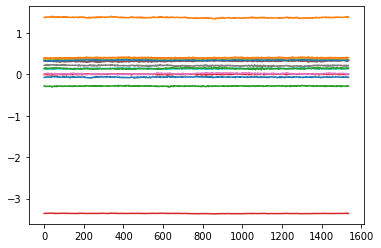


unfocused (1536, 14)


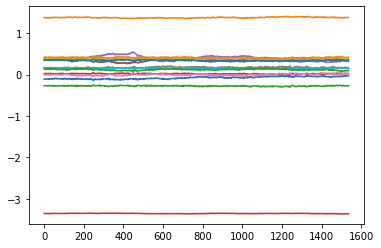


focused (1536, 14)


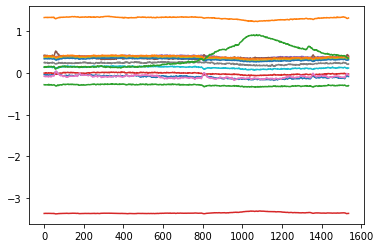


unfocused (1536, 14)


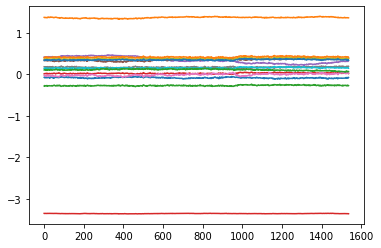


focused (1536, 14)


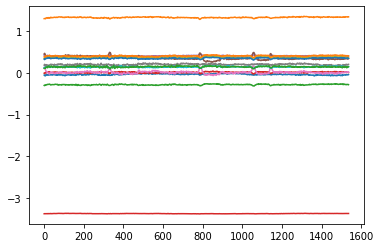


(2840, 1536, 14, 1) (2840, 3)


In [179]:
TOTAL_SAMPLES = len(x)
NUM_TRAIN = int(0.8 * TOTAL_SAMPLES)

# unshuffled so class balanced
x_train = x[:NUM_TRAIN]
y_train = y[:NUM_TRAIN]

x_test = x[NUM_TRAIN:]
y_test = y[NUM_TRAIN:]

x_train, y_train = shuffle(x_train, y_train, random_state=0)
x_test, y_test = shuffle(x_test, y_test, random_state=0)

for i in range(5):
    print(CLASSES[np.argmax(y_train[i])], x_train[i].shape)
    plt.plot(x_train[i])
    plt.show()
    print()

x_train = np.array(x_train)
x_train = np.reshape(x_train, (*x_train.shape, 1))
y_train = np.array(y_train)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (*x_test.shape, 1))
y_test = np.array(y_test)

print(x_train.shape, y_train.shape)

In [168]:
'''
https://github.com/Kearlay/research/blob/master/py/eeg_main.py
https://github.com/hauke-d/cnn-eeg/blob/master/models.py
https://backend.orbit.dtu.dk/ws/files/152316980/1_s2.0_S0957417418305359_main.pdf
'''

def create_CNN1(nchan, nclasses, trial_length=1024, l1=0, lr=1e-4):
    POOLING_STRIDES = 30

    input_shape = (trial_length, nchan, 1)
    model = Sequential()

    model.add(Conv2D(64, (60, 1), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="same", input_shape=input_shape)) # temporal convolution (30,1) 40 filters
    model.add(Conv2D(64, (1, nchan), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="valid")) # spatial convolution, inside bounds so no padding (1, 14) 40 filters

    model.add(AveragePooling2D((60, 1), strides=(POOLING_STRIDES, 1)))

    model.add(Flatten())

    model.add(Dense(1500, activation="relu"))
    model.add(Dense(300, activation="relu"))
    model.add(Dense(80, activation="relu"))

    model.add(Dense(nclasses, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(lr), metrics=["accuracy"])

    return model


def create_CNN4(nchan, nclasses, trial_length=1024, l1=0, lr=1e-4):
    POOLING_STRIDES = 15

    input_shape = (trial_length, nchan, 1)
    model = Sequential()

    model.add(Conv2D(40, (30, 1), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="same", input_shape=input_shape)) # temporal convolution (30,1) 40 filters
    model.add(Conv2D(40, (1, nchan), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="valid")) # spatial convolution, inside bounds so no padding (1, 14) 40 filters
    model.add(AveragePooling2D((30, 1), strides=(POOLING_STRIDES, 1)))
    model.add(Flatten())

    model.add(Dense(80, activation="relu"))

    model.add(Dense(nclasses, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(lr), metrics=["accuracy"])

    return model


def create_CRNN1(nchan, nclasses, trial_length=1024, l1=0, lr=1e-4, full_output=False):
    input_shape = (trial_length, nchan, 1)
    model = Sequential()
    model.add(Conv2D(40, (30, 1), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="same", input_shape=input_shape))
    model.add(Conv2D(40, (1, nchan), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="valid"))
    model.add(AveragePooling2D((5, 1), strides=(5, 1)))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(40, activation="sigmoid", dropout=0.25, return_sequences=full_output))

    model.add(Dense(15, activation="relu"))

    model.add(Dense(nclasses, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer=RMSprop(lr), metrics=["accuracy"])
    return model


def create_CRNN4(nchan, nclasses, trial_length=1024, l1=0, lr=1e-4, full_output=False):
    input_shape = (trial_length, nchan, 1)
    model = Sequential()
    model.add(Conv2D(40, (30, 1), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="same", input_shape=input_shape))
    model.add(Conv2D(40, (1, nchan), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="valid"))
    model.add(AveragePooling2D((5, 1), strides=(5, 1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(40, activation="sigmoid", dropout=0.25, return_sequences=full_output))
    model.add(Dense(nclasses, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer=RMSprop(lr), metrics=["accuracy"])
    return model


In [169]:
LR = 1e-4

model_cnn2 = create_CNN2(nchan=NUM_CHAN, nclasses=len(CLASSES), trial_length=TRIAL_LENGTH, lr=LR)
model_cnn2.summary()

model_cnn4 = create_CNN4(nchan=NUM_CHAN, nclasses=len(CLASSES), trial_length=TRIAL_LENGTH, lr=LR)
model_cnn4.summary()

model_crnn1 = create_CRNN1(nchan=NUM_CHAN, nclasses=len(CLASSES), trial_length=TRIAL_LENGTH, lr=LR)
model_crnn1.summary()

model_crnn4 = create_CRNN4(nchan=NUM_CHAN, nclasses=len(CLASSES), trial_length=TRIAL_LENGTH, lr=LR)
model_crnn4.summary()

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_184 (Conv2D)          (None, 1536, 14, 40)      1240      
_________________________________________________________________
conv2d_185 (Conv2D)          (None, 1536, 1, 40)       22440     
_________________________________________________________________
average_pooling2d_92 (Averag (None, 101, 1, 40)        0         
_________________________________________________________________
flatten_92 (Flatten)         (None, 4040)              0         
_________________________________________________________________
dense_208 (Dense)            (None, 1500)              6061500   
_________________________________________________________________
dense_209 (Dense)            (None, 300)               450300    
_________________________________________________________________
dense_210 (Dense)            (None, 80)              

In [170]:
def plot_accuracy_loss(history):
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()

    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [171]:
BATCH_SIZE = 16

Epoch 1/80
178/178 [==============================] - 9s 49ms/step - loss: 1.1132 - accuracy: 0.3330
Epoch 2/80
178/178 [==============================] - 9s 49ms/step - loss: 1.0938 - accuracy: 0.3429
Epoch 3/80
178/178 [==============================] - 9s 48ms/step - loss: 1.0901 - accuracy: 0.3477
Epoch 4/80
178/178 [==============================] - 9s 49ms/step - loss: 1.0749 - accuracy: 0.3662
Epoch 5/80
178/178 [==============================] - 9s 49ms/step - loss: 1.0718 - accuracy: 0.3700
Epoch 6/80
178/178 [==============================] - 9s 49ms/step - loss: 1.0550 - accuracy: 0.3929
Epoch 7/80
178/178 [==============================] - 9s 49ms/step - loss: 1.0432 - accuracy: 0.3989
Epoch 8/80
178/178 [==============================] - 9s 49ms/step - loss: 1.0514 - accuracy: 0.4066
Epoch 9/80
178/178 [==============================] - 9s 49ms/step - loss: 1.0238 - accuracy: 0.4186
Epoch 10/80
178/178 [==============================] - 9s 48ms/step - loss: 1.0601 - accura

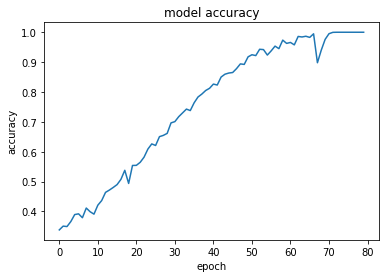

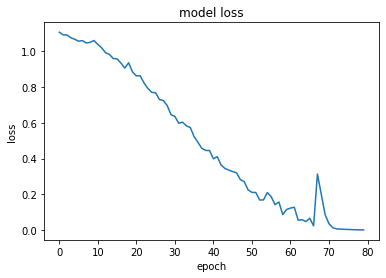

In [172]:
history = model_cnn2.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=80)
plot_accuracy_loss(history)

Epoch 1/250
178/178 [==============================] - 8s 43ms/step - loss: 1.1046 - accuracy: 0.3268
Epoch 2/250
178/178 [==============================] - 8s 44ms/step - loss: 1.0989 - accuracy: 0.3297
Epoch 3/250
178/178 [==============================] - 8s 44ms/step - loss: 1.0979 - accuracy: 0.3479
Epoch 4/250
178/178 [==============================] - 8s 44ms/step - loss: 1.0948 - accuracy: 0.3530
Epoch 5/250
178/178 [==============================] - 8s 44ms/step - loss: 1.0911 - accuracy: 0.3627
Epoch 6/250
178/178 [==============================] - 8s 44ms/step - loss: 1.0759 - accuracy: 0.3819
Epoch 7/250
178/178 [==============================] - 8s 44ms/step - loss: 1.0680 - accuracy: 0.3900
Epoch 8/250
178/178 [==============================] - 8s 43ms/step - loss: 1.0620 - accuracy: 0.4142
Epoch 9/250
178/178 [==============================] - 8s 43ms/step - loss: 1.0568 - accuracy: 0.4025
Epoch 10/250
178/178 [==============================] - 8s 43ms/step - loss: 1.046

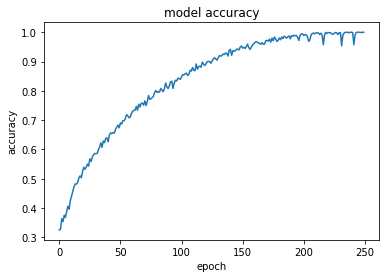

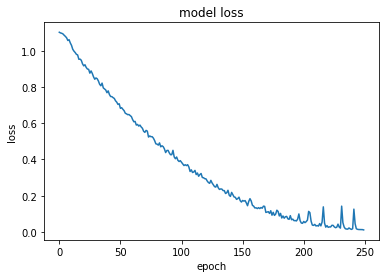

In [173]:
history = model_cnn4.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=200)
plot_accuracy_loss(history)

In [ ]:
history = model_crnn1.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=250)
plot_accuracy_loss(history)

Epoch 1/250
178/178 [==============================] - 142s 799ms/step - loss: 1.0987 - accuracy: 0.3349
Epoch 2/250
178/178 [==============================] - 143s 804ms/step - loss: 1.0985 - accuracy: 0.3335
Epoch 3/250
178/178 [==============================] - 143s 806ms/step - loss: 1.0979 - accuracy: 0.3447
Epoch 4/250
178/178 [==============================] - 141s 794ms/step - loss: 1.0975 - accuracy: 0.3398
Epoch 5/250
178/178 [==============================] - 142s 797ms/step - loss: 1.0976 - accuracy: 0.3461
Epoch 6/250
178/178 [==============================] - 140s 788ms/step - loss: 1.0971 - accuracy: 0.3542
Epoch 7/250
178/178 [==============================] - 140s 789ms/step - loss: 1.0962 - accuracy: 0.3609
Epoch 8/250
178/178 [==============================] - 140s 788ms/step - loss: 1.0952 - accuracy: 0.3613
Epoch 9/250
178/178 [==============================] - 140s 787ms/step - loss: 1.0945 - accuracy: 0.3687
Epoch 10/250
178/178 [==============================] -

In [ ]:
history = model_crnn4.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=250)
plot_accuracy_loss(history)

In [177]:
model_cnn2.save('model2')
model_cnn4.save('model4')
model_crnn1.save('model5')
model_crnn4.save('model8')

INFO:tensorflow:Assets written to: model2/assets
INFO:tensorflow:Assets written to: model4/assets
INFO:tensorflow:Assets written to: model5/assets
INFO:tensorflow:Assets written to: model8/assets


In [182]:
results = model_cnn2.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

predictions = model_cnn2.predict(x_test[:3])
print("predictions shape:", predictions.shape)


results = model_cnn4.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

predictions = model_cnn4.predict(x_test[:3])
print("predictions shape:", predictions.shape)

45/45 [==============================] - 1s 21ms/step - loss: 6.1379 - accuracy: 0.3845
test loss, test acc: [6.13786506652832, 0.38450703024864197]
predictions shape: (3, 3)
45/45 [==============================] - 1s 19ms/step - loss: 5.6660 - accuracy: 0.4296
test loss, test acc: [5.666000843048096, 0.42957746982574463]
predictions shape: (3, 3)
